In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import altair as alt
import pycountry

from vega_datasets import data
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [237]:
# Load the data

df = pd.read_excel('../data/eurovision_song_contest.xlsx')

In [238]:
# Make column names snake_case

df = df.rename(str.lower, axis='columns')
df = df.rename(columns={'(semi-) final': 'semi_final',
                        'jury or televoting': 'jury_televoting',
                        'from country': 'from_country',
                        'to country': 'to_country',
                        'points      ': 'points'})

In [239]:
# Drop rows where `from_country` and `to_country` are the same
# Only include votes from the jury at the finals

df = df[(df['duplicate'] != 'x') & 
        (df['semi_final'] == 'f') &
        (df['jury_televoting'] == 'J')]
df = df.drop(columns='duplicate')

In [240]:
df.head()

,year,semi_final,edition,jury_televoting,from_country,to_country,points
1,1975,f,1975f,J,Belgium,Finland,0
2,1975,f,1975f,J,Belgium,France,2
3,1975,f,1975f,J,Belgium,Germany,0
4,1975,f,1975f,J,Belgium,Ireland,12
5,1975,f,1975f,J,Belgium,Israel,1


In [241]:
# Remove Serbia & Montenegro (ended in 2006)

df = df[(df['from_country'] != 'Serbia & Montenegro') & (df['to_country'] != 'Serbia & Montenegro')]

# Change naming of Macedonia

df['from_country'] = df.from_country.str.replace('F.Y.R. Macedonia', 'North Macedonia', regex=False)
df['to_country'] = df.to_country.str.replace('F.Y.R. Macedonia', 'North Macedonia', regex=False)

# Change & to 'and' to make it easier to retrieve country codes later
df['from_country'] = df.from_country.str.replace('&', 'and', regex=False)
df['to_country'] = df.to_country.str.replace('&', 'and', regex=False)

In [242]:
# Create new column to make it easier to pivot columns later

df['to_country_year'] = df['to_country'] + df.year.map(str)

In [243]:
# Check for duplicate entries

df[df.duplicated(['from_country', 'to_country_year'])]

,year,semi_final,edition,jury_televoting,from_country,to_country,points,to_country_year
49831,2019,f,2019f,J,Belarus,Russia,1,Russia2019


In [244]:
df.query("from_country == 'Belarus' and to_country_year == 'Russia2019'")

,year,semi_final,edition,jury_televoting,from_country,to_country,points,to_country_year
49810,2019,f,2019f,J,Belarus,Russia,0,Russia2019
49831,2019,f,2019f,J,Belarus,Russia,1,Russia2019


According to [this scoreboard](https://eurovisionworld.com/eurovision/2019), Belarus gave Russia 1 point that year.

In [245]:
# Keep the correct observation

df = df[~(df['from_country'] == 'Belarus') |
        ~(df['to_country_year'] == 'Russia2019') |
        ~(df['points'] == 0)]

In [246]:
# Drop observations from before 2000

df = df.query('year > 1999')

In [255]:
plot_df = df.loc[:, ['from_country', 'points', 'to_country_year']]

In [256]:
plot_df = plot_df.pivot(index='from_country', columns='to_country_year', values='points')
plot_df.head(10)

to_country_year,Albania2004,Albania2005,Albania2008,Albania2009,Albania2010,Albania2012,Albania2015,Albania2018,Albania2019,Armenia2006,...,United Kingdom2010,United Kingdom2011,United Kingdom2012,United Kingdom2013,United Kingdom2014,United Kingdom2015,United Kingdom2016,United Kingdom2017,United Kingdom2018,United Kingdom2019
from_country,,,,,,,,,,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,1.0,6.0,0.0,0.0,0.0,0.0,5.0,8.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Armenia,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,0.0,2.0,NaN,0.0,0.0,0.0,0.0,4.0,0.0,2.0
Australia,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,4.0,12.0,0.0,0.0
Austria,5.0,3.0,NaN,NaN,NaN,8.0,0.0,7.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Azerbaijan,NaN,NaN,1.0,0.0,0.0,0.0,0.0,12.0,7.0,NaN,...,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,8.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,1.0,0.0,0.0,0.0,3.0,10.0,6.0,2.0,0.0,12.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
Bosnia and Herzegovina,4.0,5.0,1.0,0.0,5.0,6.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [259]:
# Fill in missing values
for country in plot_df.index:
    row = plot_df.loc[country, :]
    for i in range(len(row)):
        # if entry has a NaN
        if np.isnan(row[i]):
            # if it's missing for itself
            if country in row.index[i]:
                row[i] = 12
            # if it's missing for another country
            else:
                row[i] = 0 # mode score given is 0
                
plot_df.head()

to_country_year,Albania2004,Albania2005,Albania2008,Albania2009,Albania2010,Albania2012,Albania2015,Albania2018,Albania2019,Armenia2006,...,United Kingdom2010,United Kingdom2011,United Kingdom2012,United Kingdom2013,United Kingdom2014,United Kingdom2015,United Kingdom2016,United Kingdom2017,United Kingdom2018,United Kingdom2019
from_country,,,,,,,,,,,,,,,,,,,,,
Albania,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0,...,1.0,6.0,0.0,0.0,0.0,0.0,5.0,8.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0
Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,12.0,0.0,0.0
Austria,5.0,3.0,0.0,0.0,0.0,8.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [272]:
# Check that there are no missing values (or can't plot dendrogram)

plot_df.isna().sum().sum() == 0

True

In [273]:
# Code attribution: Rodolfo Lourenzutti (DSCI 563)

def plot_dendrogram(data, method, metric, w=20, h=10):
    """Plot a dendrogram given clustering method and distance measure."""
    Z = linkage(data, method=method, metric=metric)
    fig, ax = plt.subplots(figsize=(w, h))
    dendrogram(Z, labels=data.index, ax=ax)
    ax = plt.gca()
    ax.set_ylabel("Euclidean distance", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, fontsize=18)

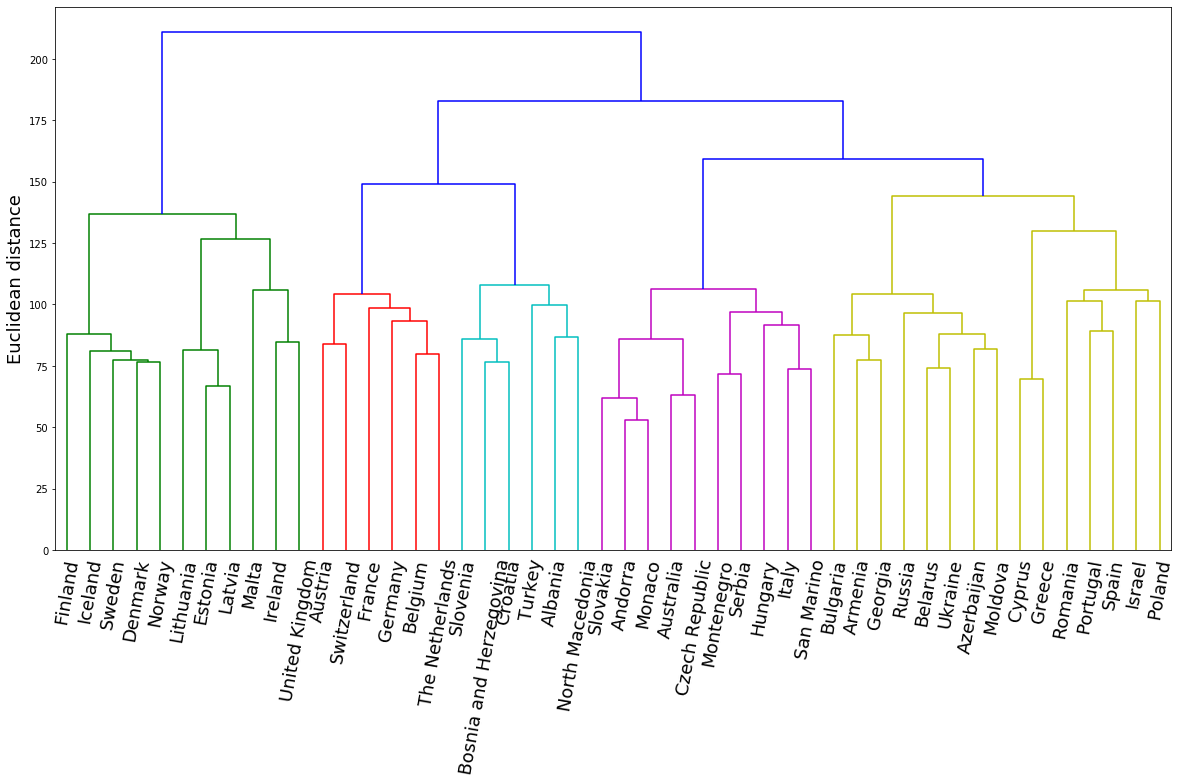

In [276]:
plot_dendrogram(plot_df, 'ward', 'euclidean')

In [277]:
# Extract label for each country

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
label = cluster.fit_predict(plot_df)

In [278]:
# Retrieve ISO 3166 country codes needed to plot choropleth map

codes = []
for i in range(len(plot_df.index)):
    codes.append(pycountry.countries.search_fuzzy(plot_df.index[i])[0].numeric.lstrip('0'))

In [285]:
choro_dict = {'country': plot_df.index.to_list(), 'id': codes, 'label': label}
choro_df = pd.DataFrame(choro_dict)

In [292]:
# https://stackoverflow.com/questions/61135952/vega-lite-altair-how-to-center-or-crop-a-map-of-europe
countries = alt.topo_feature(data.world_110m.url, 'countries')

choropleth = (alt
              .Chart(countries)
              .mark_geoshape(stroke='white')
              .encode(alt.Color('label:N', title='Group'))
              .transform_lookup(lookup='id',
                                from_=alt.LookupData(choro_df, 'id', ['label']))
              .project(type= 'mercator',
                       scale=400,
                       center=[15, 55],
                       clipExtent= [[0, 0], 
                                    [600, 450]])
              .properties(title='Eurovision voting blocs',
                          width=600, 
                          height=450
                         )
             )

choropleth

alt.Chart(...)